### Installation librairies

In [1]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1695123410181_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1695123410181_0001,pyspark,idle,Link,Link,None,✔


In [5]:
sc = spark.sparkContext

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Chemins Images et chargement

In [6]:
PATH = 's3://s3p8corentinjay'
PATH_Data = PATH+'/Test'
PATH_Results = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Results: '+PATH_Results)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://s3p8corentinjay
PATH_Data:   s3://s3p8corentinjay/Test
PATH_Result: s3://s3p8corentinjay/Results

In [7]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://s3p8corentin...|2023-09-15 14:39:37|  6304|[FF D8 FF E0 00 1...|
|s3://s3p8corentin...|2023-09-15 14:39:37|  6277|[FF D8 FF E0 00 1...|
|s3://s3p8corentin...|2023-09-15 14:39:36|  6231|[FF D8 FF E0 00 1...|
|s3://s3p8corentin...|2023-09-15 14:39:32|  6220|[FF D8 FF E0 00 1...|
|s3://s3p8corentin...|2023-09-15 14:39:36|  6217|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

#### Sélection colonnes et ajout labels

In [9]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(25,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------+--------------+
|path                                                |label         |
+----------------------------------------------------+--------------+
|s3://s3p8corentinjay/Test/Apple Golden 1/96_100.jpg |Apple Golden 1|
|s3://s3p8corentinjay/Test/Apple Golden 1/95_100.jpg |Apple Golden 1|
|s3://s3p8corentinjay/Test/Apple Golden 1/94_100.jpg |Apple Golden 1|
|s3://s3p8corentinjay/Test/Apple Golden 1/104_100.jpg|Apple Golden 1|
|s3://s3p8corentinjay/Test/Apple Golden 1/93_100.jpg |Apple Golden 1|
|s3://s3p8corentinjay/Test/Apple Golden 1/119_100.jpg|Apple Golden 1|
|s3://s3p8corentinjay/Test/Apple Golden 1/84_100.jpg |Apple Golden 1|
|s3://s3p8corentinjay/Test/Apple Golden 1/86_100.jpg |Apple Golden 1|
|s3://s3p8corentinja

#### Préparation du modèle

In [10]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14536120/14536120 [==============================] - 1s 0us/step

In [11]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1695123410181_0001/container_1695123410181_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:398: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

#### Extraction des features des images

In [16]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
print(PATH_Results)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://s3p8corentinjay/Results

In [18]:
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Chargement des données enregistrées

In [19]:
# Ouverture du fichier au format parquet
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Aperçu
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                           features
0  s3://s3p8corentinjay/Test/Apple Golden 1/72_10...  ...  [0.0, 0.05176872, 0.010632622, 0.0, 0.0, 0.0, ...
1          s3://s3p8corentinjay/Test/Kiwi/44_100.jpg  ...  [0.7344478, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.53...
2     s3://s3p8corentinjay/Test/Blueberry/30_100.jpg  ...  [0.6798401, 0.1693784, 0.0, 0.10660808, 0.0585...
3  s3://s3p8corentinjay/Test/Apple Golden 1/85_10...  ...  [0.0, 0.022609487, 0.37422004, 0.0, 0.02660995...
4           s3://s3p8corentinjay/Test/Kiwi/9_100.jpg  ...  [0.9519107, 0.0, 0.0, 0.0029155284, 0.0, 0.0, ...

[5 rows x 3 columns]

In [21]:
# Format de la colonne features (array)
df.loc[0,'features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

### Réduction de dimension (PCA k=2)

In [ ]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import PCA
from pyspark.sql import functions as F

In [37]:
# Vectorisation de la colonne features
to_vector = F.udf(lambda x: Vectors.dense(x), VectorUDT())
sparkDF = features_df.select('path', 'label','features', to_vector("features").alias("features_vec"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
# Aperçu du fichier après transformation
sparkDF.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features|        features_vec|
+--------------------+--------------+--------------------+--------------------+
|s3://s3p8corentin...|Apple Golden 1|[0.0, 0.05176872,...|[0.0,0.0517687201...|
|s3://s3p8corentin...|          Kiwi|[0.7344478, 0.0, ...|[0.73444777727127...|
|s3://s3p8corentin...|     Blueberry|[0.6798401, 0.169...|[0.67984008789062...|
|s3://s3p8corentin...|Apple Golden 1|[0.0, 0.022609487...|[0.0,0.0226094871...|
|s3://s3p8corentin...|          Kiwi|[0.9519107, 0.0, ...|[0.95191067457199...|
+--------------------+--------------+--------------------+--------------------+
only showing top 5 rows

In [41]:
# Utilisation du PCA (k=2)
pcaSparkEstimator = PCA(inputCol="features_vec", outputCol="pca_Features", k=2)
pca = pcaSparkEstimator.fit(sparkDF)
pca_matrix=pca.transform(sparkDF)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
# Aperçu du fichier après réduction de dimension
pca_matrix.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         label|            features|        features_vec|        pca_Features|
+--------------------+--------------+--------------------+--------------------+--------------------+
|s3://s3p8corentin...|Apple Golden 1|[0.0, 0.05176872,...|[0.0,0.0517687201...|[3.90602536096789...|
|s3://s3p8corentin...|          Kiwi|[0.7344478, 0.0, ...|[0.73444777727127...|[1.61327350587742...|
|s3://s3p8corentin...|     Blueberry|[0.6798401, 0.169...|[0.67984008789062...|[-18.679180859050...|
|s3://s3p8corentin...|Apple Golden 1|[0.0, 0.022609487...|[0.0,0.0226094871...|[4.05523933523759...|
|s3://s3p8corentin...|          Kiwi|[0.9519107, 0.0, ...|[0.95191067457199...|[1.91753014252427...|
+--------------------+--------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [46]:
# Sélection des colonnes retenues
pca_matrix_final = pca_matrix.select('path','label','pca_Features')

# Aperçu des 5 première lignes
pca_matrix_final.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+
|                path|         label|        pca_Features|
+--------------------+--------------+--------------------+
|s3://s3p8corentin...|Apple Golden 1|[3.90602536096789...|
|s3://s3p8corentin...|          Kiwi|[1.61327350587742...|
|s3://s3p8corentin...|     Blueberry|[-18.679180859050...|
|s3://s3p8corentin...|Apple Golden 1|[4.05523933523759...|
|s3://s3p8corentin...|          Kiwi|[1.91753014252427...|
+--------------------+--------------+--------------------+
only showing top 5 rows

### Sauvegarde du résultat au format .csv 

In [57]:
pca_matrix_final.toPandas().to_csv('Final_results.csv')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Représentation graphique

In [16]:
# Import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Transformation des pca_Features en array à deux dimensions
pca_matrix_final['pca_Features'] = pca_matrix_final['pca_Features'].apply(eval)

# Séparation des deux dimensions
pca_matrix_final['dim_1'] = pca_matrix_final['pca_Features'].apply(lambda x: x[0])
pca_matrix_final['dim_2'] = pca_matrix_final['pca_Features'].apply(lambda x: x[1])

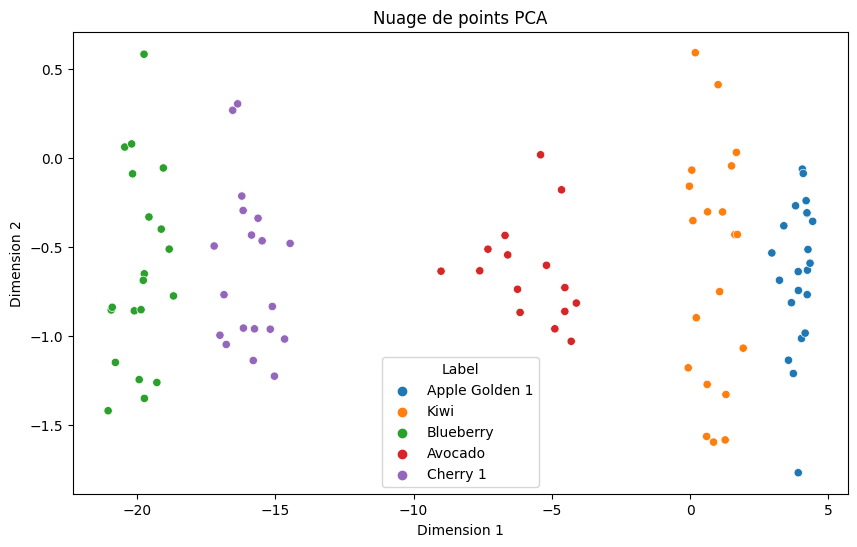

In [23]:
# Nuage de points
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_matrix_final, x='dim_1', y='dim_2', hue='label')

plt.title("Nuage de points PCA")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title='Label')

plt.show()